# Project Group - 22

Members: Charlotte Koning, Cleo Vos, Koen Awater, Jasmijn van de Kar, Jippo Steenstra

Student numbers: 5414164, 5324599, 5416493, 5315611, 5064740

# Research Objective

*Requires data modeling and quantitative research in Transport, Infrastructure & Logistics*

Main Research Question:

To what extent can anomalous peaks in pedestrian flow be predicted up to 15 minutes in advance using historical sensor data and temporal features?

Sub questions:
1.	How can anomalous crowd behaviour be quantitatively defined within the dataset?
2.	Which sensor locations show the highest likelihood of anomalies?
3.	How accurately can different models (e.g., Logistic Regression, Random Forest, XGBoost) predict anomalies?
4.	Which features (temporal, spatial, or meteorological) contribute most to prediction accuracy?

# Contribution Statement

Be specific. Some of the tasks can be coding (expect everyone to do this), background research, conceptualisation, visualisation, data analysis, data modelling

**Author 1**:

**Author 2**:

**Author 3**:

# Data Used

We will use the dataset(s) about the SAIL event, provided by the professors.

# Data Pipeline

For the geographical scale we will use eastern harbor of Amsterdam IJhaven, across the IJ river. The temporal scale of the project will be the 20-24 august 2025. For data preperation we will use the Panda library in python.

In [10]:
import pandas as pd
import chardet
import os
import matplotlib.pyplot as plt
import calendar
import numpy as np
from scipy.interpolate import make_interp_spline
from sklearn.ensemble import HistGradientBoostingRegressor, HistGradientBoostingClassifier
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from scipy.signal import find_peaks
from collections import deque
import sklearn

In [2]:
flow_file = 'SAIL2025_LVMA_data_3min_20August-25August2025_flow.csv'
location_file = 'sensor-location.xlsx'

with open(flow_file, 'rb') as f:
    result = chardet.detect(f.read())

enc = result['encoding']

df_flow = pd.read_csv(flow_file, encoding=enc)


with open(location_file, 'rb') as f:
    result = chardet.detect(f.read())


df_location = pd.read_excel(location_file)

To do: Filter data to only a few sensors

In [3]:
df_flow.head(3)


,timestamp,CMSA-GAKH-01_0,CMSA-GAKH-01_180,CMSA-GAWW-11_120,CMSA-GAWW-11_300,CMSA-GAWW-12_115,CMSA-GAWW-12_295,CMSA-GAWW-13_120,CMSA-GAWW-13_300,CMSA-GAWW-14_40,...,GVCV-13_10,GVCV-13_190,GVCV-14_90,GVCV-14_270,hour,minute,day,month,weekday,is_weekend
0,2025-08-20 00:00:00+02:00,15,4,29,33,44,28,42,37,11,...,41,40,0,0,0,0,20,8,2,0
1,2025-08-20 00:03:00+02:00,1,3,21,29,34,39,9,14,6,...,0,0,0,0,0,3,20,8,2,0
2,2025-08-20 00:06:00+02:00,5,4,35,22,29,34,33,42,14,...,0,0,0,0,0,6,20,8,2,0


To do: delete histogram

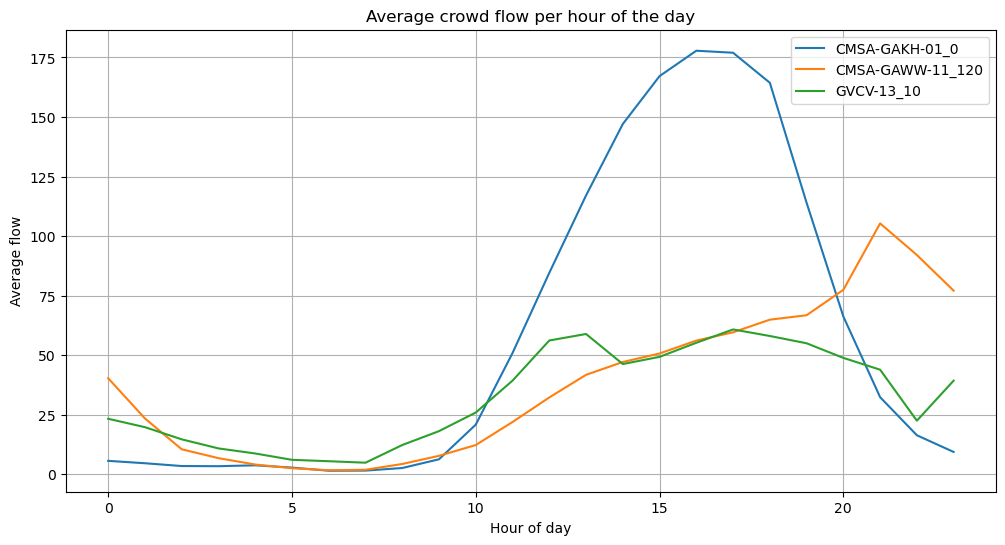

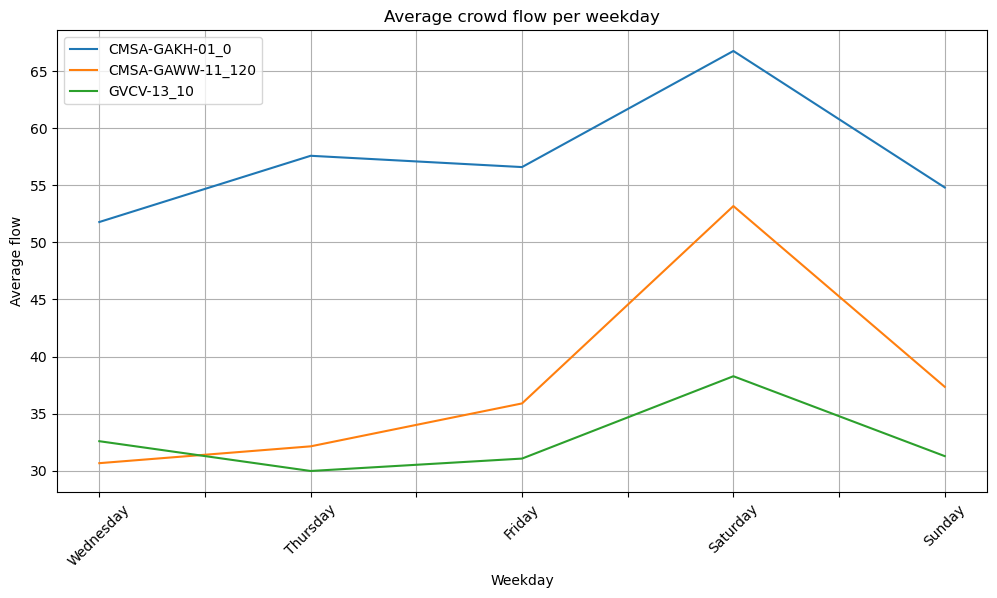

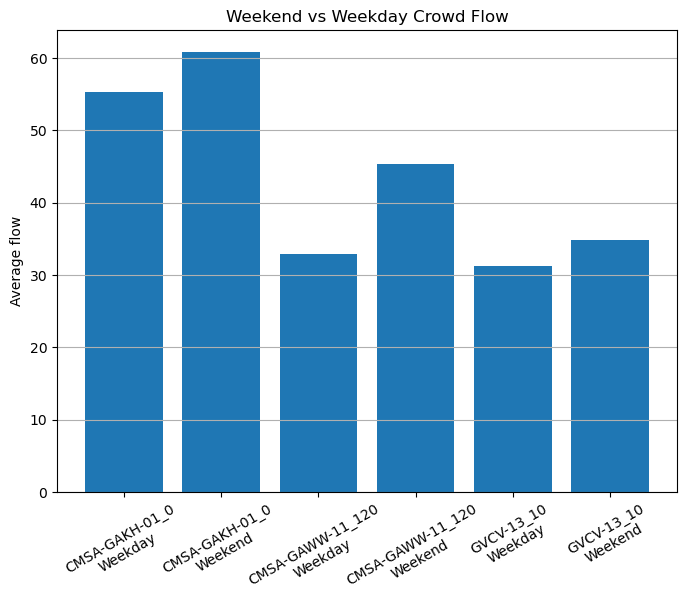

In [4]:
sensors = ["CMSA-GAKH-01_0", "CMSA-GAWW-11_120", "GVCV-13_10"]

# 1. Hourly plot (unchanged)
plt.figure(figsize=(12, 6))
for sensor in sensors:
    df_flow.groupby("hour")[sensor].mean().plot(label=sensor)
plt.title("Average crowd flow per hour of the day")
plt.xlabel("Hour of day")
plt.ylabel("Average flow")
plt.legend()
plt.grid(True)
plt.show()

# 2. Weekday plot with names instead of numbers
# Create mapping: 0 = Monday, 6 = Sunday
weekday_names = [calendar.day_name[i] for i in range(7)]

plt.figure(figsize=(12, 6))
for sensor in sensors:
    weekday_means = df_flow.groupby("weekday")[sensor].mean()
    weekday_means.index = [weekday_names[i] for i in weekday_means.index]
    weekday_means.plot(label=sensor)

plt.title("Average crowd flow per weekday")
plt.xlabel("Weekday")
plt.ylabel("Average flow")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

# 3. Weekend vs Weekday bar plot
plt.figure(figsize=(8, 6))
means = []
labels = []
for sensor in sensors:
    weekend_mean = df_flow[df_flow["is_weekend"] == 1][sensor].mean()
    weekday_mean = df_flow[df_flow["is_weekend"] == 0][sensor].mean()
    means.extend([weekday_mean, weekend_mean])
    labels.extend([f"{sensor}\nWeekday", f"{sensor}\nWeekend"])

plt.bar(labels, means)
plt.title("Weekend vs Weekday Crowd Flow")
plt.ylabel("Average flow")
plt.xticks(rotation=30)
plt.grid(axis='y')
plt.show()


📡 Plotting sensor: CMSA-GAWW-12_295


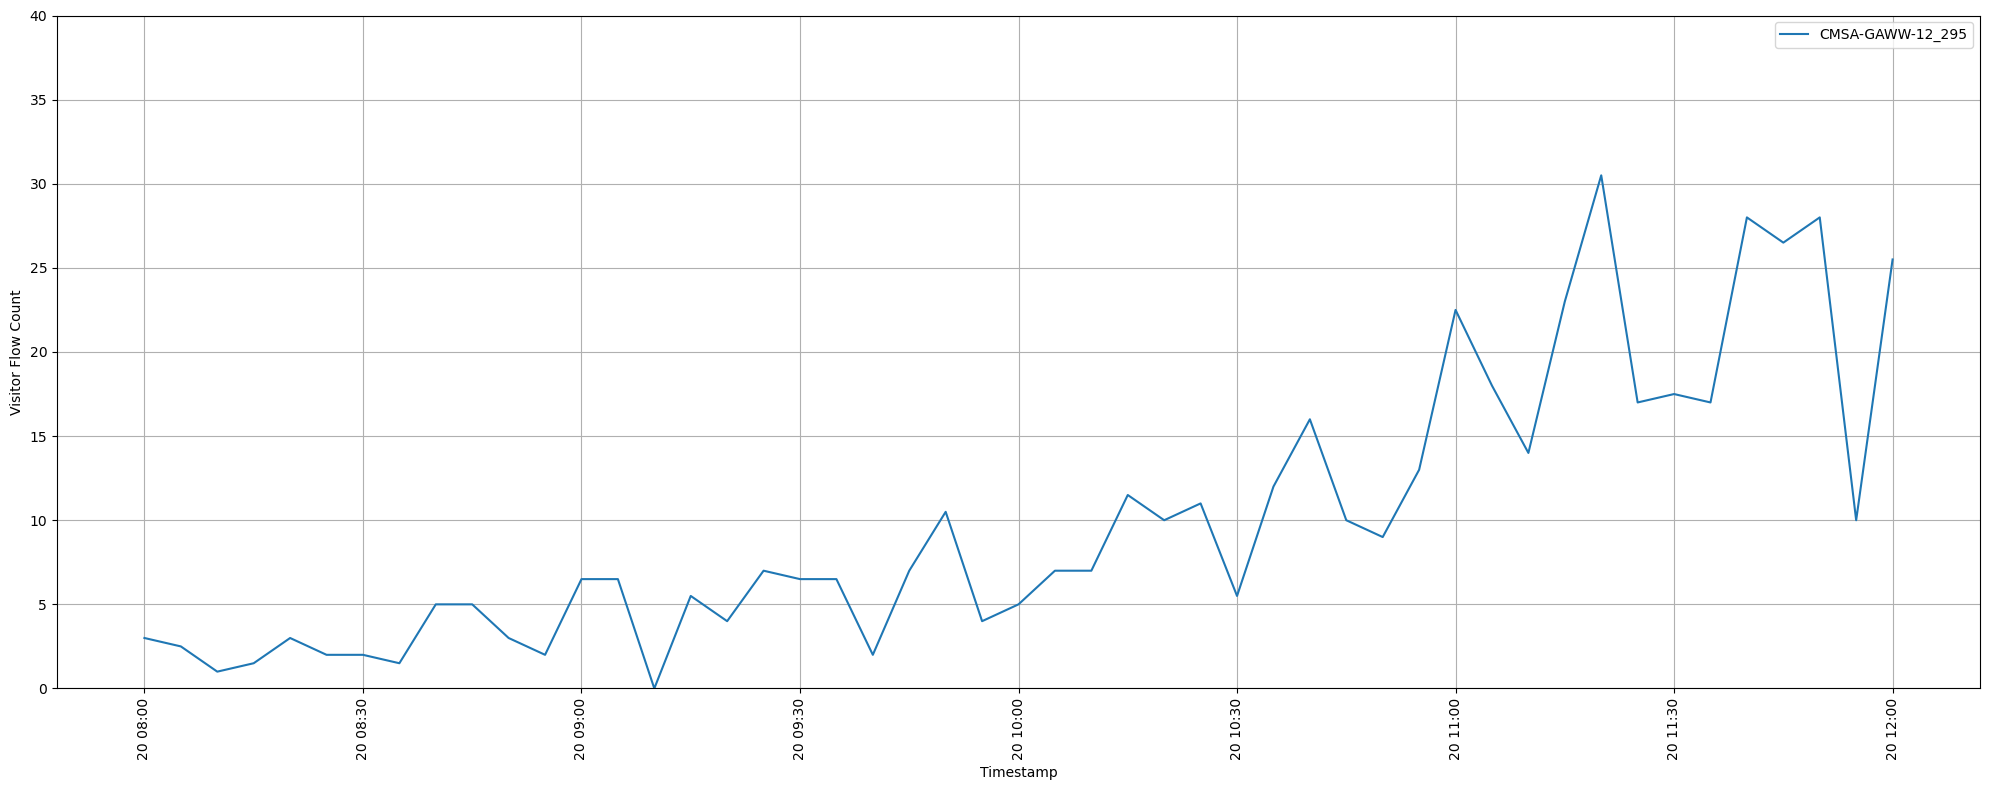

In [5]:
sensor_columns = [c for c in df_flow.columns
                  if c not in ["timestamp","hour","minute","day","month","weekday","is_weekend"]]
random_sensor = np.random.choice(sensor_columns)
print(f"📡 Plotting sensor: {random_sensor}")

df_flow["timestamp"] = pd.to_datetime(df_flow["timestamp"])
df_flow = df_flow.sort_values("timestamp")

series = (
    df_flow.set_index("timestamp")[random_sensor]
           .resample("5min").mean()   
)

day0 = series.index.normalize()[0]
start = day0 + pd.Timedelta(hours=8)
end   = day0 + pd.Timedelta(hours=12)
window = series.loc[start:end]

full_index = pd.date_range(start=start, end=end, freq="5min")  

plt.figure(figsize=(20, 8))
plt.plot(window.index, window.values, label=random_sensor, linewidth=1.5)  
plt.xlabel("Timestamp")
plt.ylabel("Visitor Flow Count")
plt.xticks(rotation=90)

ymax = 20 * int(np.ceil((np.nanmax(window.values) if np.isfinite(np.nanmax(window.values)) else 0) / 20.0))
plt.ylim(0, max(20, ymax))

plt.grid(True)
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()


In [6]:
#sklearn

To do: Delete first plot and delete third column

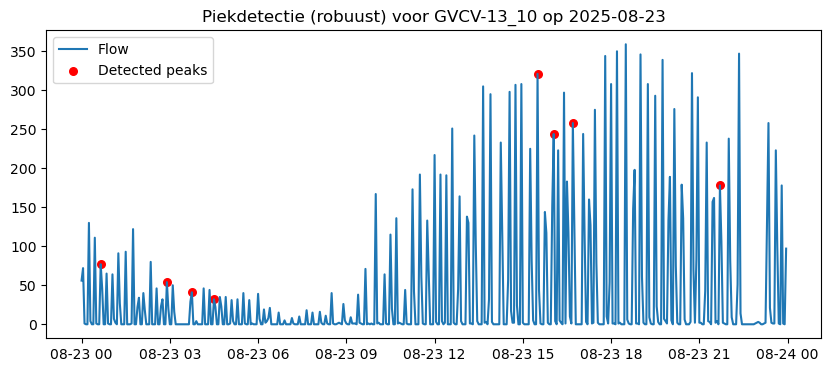

In [7]:
sensor = "GVCV-13_10"  # of een van je andere twee

data = df_flow[["timestamp", sensor]].copy()
y = data[sensor].astype(float)

# 1) Robuuste baseline + residu (voorkomt dat elke bult een piek wordt)
baseline = y.rolling(5, center=True, min_periods=1).median()   # ~15 min gladstrijken (3-min data)
resid = y - baseline

# 2) Robuuste schaal (MAD) voor drempels
mad = 1.4826 * np.median(np.abs(resid - np.median(resid)))
mad = max(mad, 1.0)  # ondergrens zodat niet te klein

# 3) Piekdetectie met strengere parameters
# - prominence: minstens 3×MAD boven lokale omgeving
# - distance: minimaal 6 samples (≈18 min) tussen pieken
# - width: piek moet minimaal ~2 samples breed zijn
peaks, props = find_peaks(
    resid.values,
    prominence=3*mad,
    distance=6,
    width=1.5
)

# 4) Extra filter: absolute hoogte moet ook boven baseline + drempel
abs_filter = y.iloc[peaks].values > (baseline.iloc[peaks].values + max(15, 2*mad))
peaks = peaks[abs_filter]

# Plotten in een kort venster (bijv. 1 dag)
day = pd.Timestamp("2025-08-23").date()
mask = data["timestamp"].dt.date == day

plt.figure(figsize=(10,4))
plt.plot(data.loc[mask, "timestamp"], y[mask], label="Flow")
sel = mask.to_numpy().nonzero()[0]
show_idx = np.intersect1d(np.where(mask)[0], peaks)
plt.scatter(data.iloc[show_idx]["timestamp"], y.iloc[show_idx],
            s=30, color="red", label="Detected peaks")
plt.title(f"Piekdetectie (robuust) voor {sensor} op {day}")
plt.legend()
plt.show()


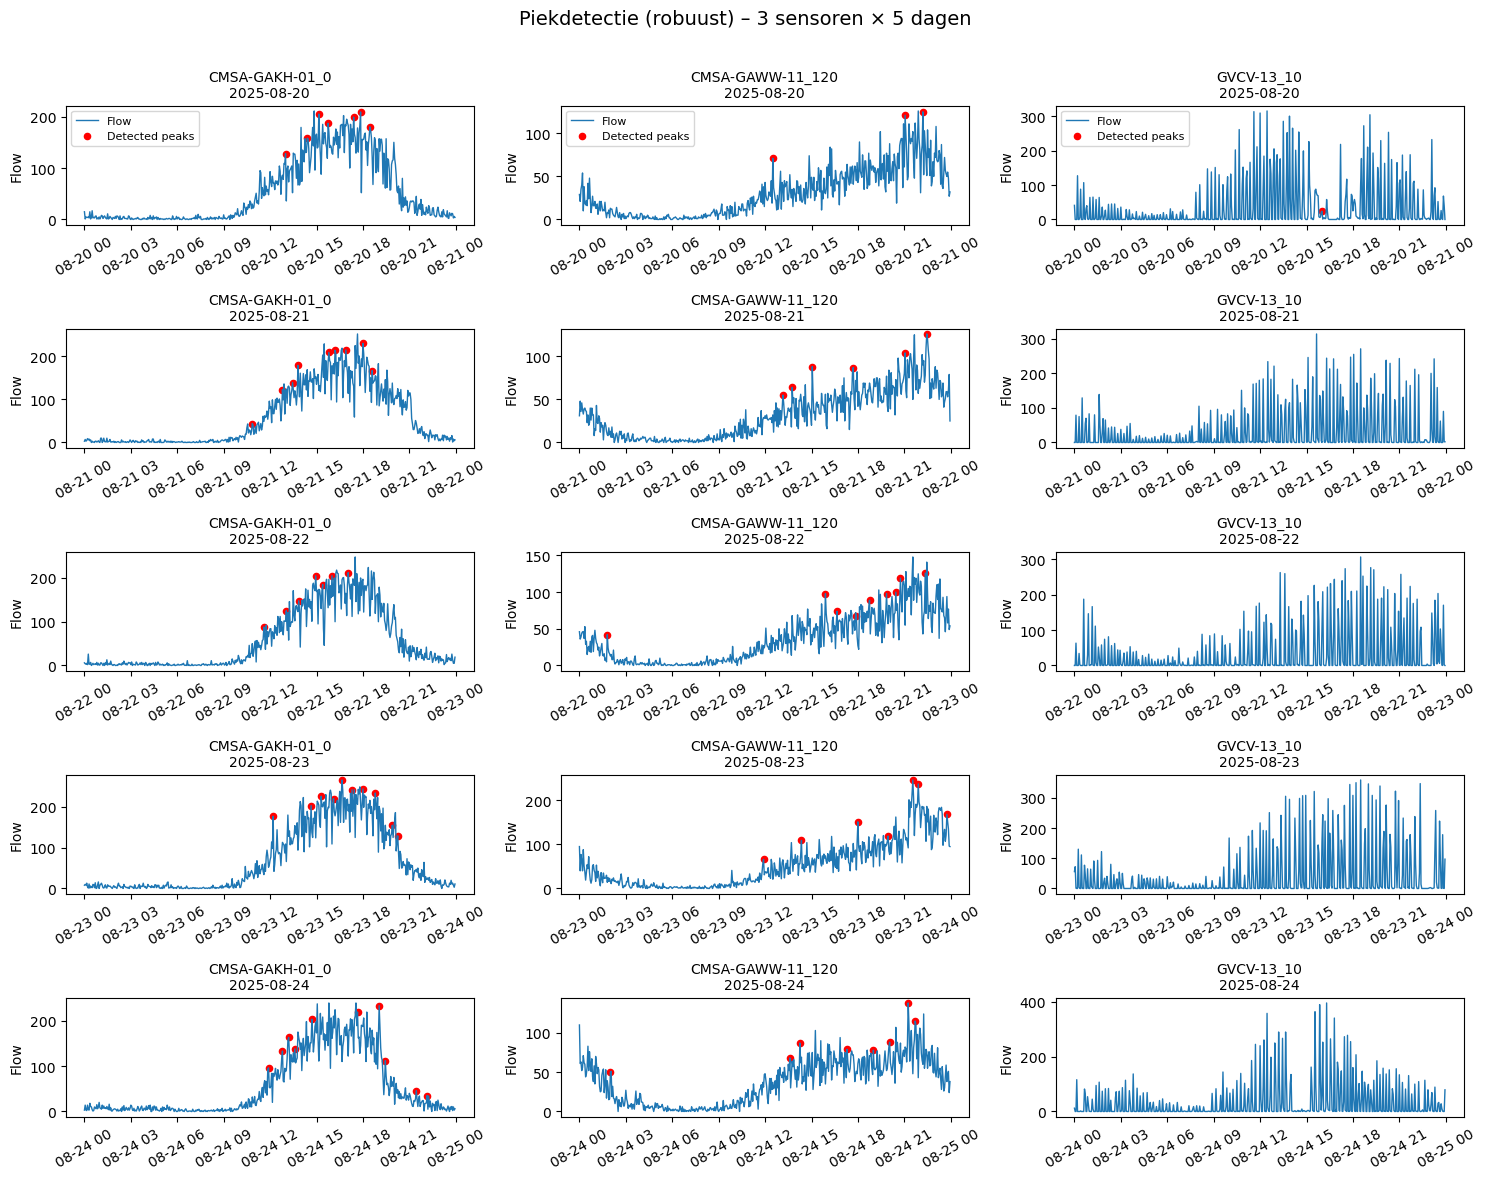

In [8]:
SENSORS = ["CMSA-GAKH-01_0", "CMSA-GAWW-11_120", "GVCV-13_10"]

# Data voorbereiden
df_flow["timestamp"] = pd.to_datetime(df_flow["timestamp"])
df = df_flow.sort_values("timestamp")

# === Instellingen voor piekdetectie ===
SAMPLE_MIN   = 3
SMOOTH_WIN   = 5
PROM_MAD     = 3.0
MIN_DIST     = 6
MIN_WIDTH    = 2
ABS_FLOOR    = 15
ABS_MAD_MULT = 2.0

def robust_peaks(y: pd.Series):
    baseline = y.rolling(SMOOTH_WIN, center=True, min_periods=1).median()
    resid = y - baseline
    mad = 1.4826 * np.median(np.abs(resid - np.median(resid)))
    mad = max(mad, 1.0)
    peaks, props = find_peaks(
        resid.values,
        prominence=PROM_MAD * mad,
        distance=MIN_DIST,
        width=MIN_WIDTH
    )
    keep = y.iloc[peaks].values > (baseline.iloc[peaks].values + max(ABS_FLOOR, ABS_MAD_MULT*mad))
    peaks = peaks[keep]
    return peaks

# === Dagen selecteren ===
days = sorted(df["timestamp"].dt.date.unique())[:5]  # eerste 5 dagen (20-24 aug)

# === Plot: 5 rijen (dagen) × 3 kolommen (sensoren) ===
fig, axes = plt.subplots(len(days), len(SENSORS), figsize=(15, 12), sharex=False)
fig.subplots_adjust(hspace=0.4, wspace=0.3)

for i, day in enumerate(days):
    mask_day = df["timestamp"].dt.date == day

    for j, sensor in enumerate(SENSORS):
        ax = axes[i, j]
        y = df[sensor].astype(float)
        peaks = robust_peaks(y)

        idx_day = np.where(mask_day)[0]
        day_peaks_idx = sorted(set(idx_day).intersection(peaks))

        ax.plot(df.loc[mask_day, "timestamp"], y[mask_day], label="Flow", lw=1)
        if day_peaks_idx:
            ax.scatter(df.iloc[day_peaks_idx]["timestamp"], y.iloc[day_peaks_idx],
                       s=20, color="red", label="Detected peaks")
        ax.set_title(f"{sensor}\n{day}", fontsize=10)
        ax.set_ylabel("Flow")
        ax.tick_params(axis='x', rotation=30)
        if i == 0:
            ax.legend(fontsize=8)

plt.suptitle("Piekdetectie (robuust) – 3 sensoren × 5 dagen", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

In [9]:
# ==============================
# 1) Feature/Train set builder
# ==============================
def build_training_set(df, sensor, FREQ_MIN=3,
                       LAGS=(1,2,3,4,5,10,20), ROLLS=(5,10,20),
                       HORIZON_STEPS=1):
    """
    Maakt features voor one-step-ahead (default 1 stap = FREQ_MIN minuten).
    Retourneert X, y, feature_cols, Xy (met tijdkolom), HORIZON_STEPS, data_original
    """
    TIME_COL = "timestamp"
    df = df.sort_values(TIME_COL).copy()
    df[TIME_COL] = pd.to_datetime(df[TIME_COL], utc=True).dt.tz_convert(None)
    data = df[[TIME_COL, sensor]].rename(columns={sensor: "count"}).dropna()

    def add_features(x):
        x = x.copy()
        x["hour"] = x[TIME_COL].dt.hour
        x["dow"]  = x[TIME_COL].dt.dayofweek
        x["sin_hour"] = np.sin(2*np.pi*x["hour"]/24)
        x["cos_hour"] = np.cos(2*np.pi*x["hour"]/24)
        x["sin_dow"]  = np.sin(2*np.pi*x["dow"]/7)
        x["cos_dow"]  = np.cos(2*np.pi*x["dow"]/7)

        # lags
        for L in LAGS:
            x[f"lag_{L}"] = x["count"].shift(L)

        # rollings (op vorige waarden)
        for w in ROLLS:
            rsrc = x["count"].shift(1).rolling(w, min_periods=1)
            x[f"roll_mean_{w}"] = rsrc.mean()
            x[f"roll_std_{w}"]  = rsrc.std(ddof=0)
            x[f"roll_max_{w}"]  = rsrc.max()

        # piek-signaal features
        x["delta1"] = x["count"].diff(1).fillna(0.0)
        x["delta2"] = x["delta1"].diff(1).fillna(0.0)
        x["roll_max_3"] = x["count"].shift(1).rolling(3, min_periods=1).max()
        x["roll_q90_9"] = x["count"].shift(1).rolling(9, min_periods=1).quantile(0.9)

        # target 1 stap vooruit
        x["y_horizon"] = x["count"].shift(-HORIZON_STEPS)
        return x

    Xy = add_features(data)
    need_cols = [f"lag_{L}" for L in LAGS] + ["y_horizon"]
    Xy = Xy.dropna(subset=need_cols).reset_index(drop=True)

    # kolommen voor het model
    base_feats = [c for c in Xy.columns if c.startswith(("lag_","roll_","sin_","cos_"))]
    extra_feats = ["delta1","delta2","roll_max_3","roll_q90_9"]
    feature_cols = [c for c in base_feats + extra_feats if c in Xy.columns]

    X = Xy[feature_cols].values
    y = Xy["y_horizon"].values
    return X, y, feature_cols, Xy, HORIZON_STEPS, data

# ==============================
# 2) Poisson-trainer (fallback naar quantile)
# ==============================
def train_peak_model(X, y, Xy_train, random_state=42, use_peak_weights=True):
    """
    Probeert HGBR met loss='poisson'. Valt terug op
    GradientBoostingRegressor met quantile-loss als het niet kan.
    """
    assert (y >= 0).all(), "Poisson/quantile verwachten niet-negatieve counts."

    # gewichten om pieken nadruk te geven (optioneel)
    sample_weight = None
    if use_peak_weights:
        base = Xy_train["count"].rolling(20, min_periods=1).mean()
        dev  = (Xy_train["count"] - base).clip(lower=0)
        w = 1.0 + (dev / (dev.std() + 1e-6))
        sample_weight = np.asarray(w[:len(y)], dtype=float)

    # Probeer Poisson HGBR; als niet beschikbaar of training faalt -> fallback
    try:
        model = HistGradientBoostingRegressor(
            loss="poisson",
            learning_rate=0.05,
            max_iter=500,
            max_depth=None,
            max_bins=255,
            min_samples_leaf=20,
            early_stopping=True,
            validation_fraction=0.1,
            l2_regularization=0.0,
            random_state=random_state,
        )
        model.fit(X, y, sample_weight=sample_weight)
        return model
    except TypeError:
        pass  # loss-parameter niet ondersteund in deze sklearn
    except Exception:
        pass  # training faalde; gebruik fallback

    # Fallback: quantile modellen (median + hoge kwantiel) en blenden richting bovenkant
    q_hi = GradientBoostingRegressor(
        loss="quantile", alpha=0.90,
        n_estimators=600, learning_rate=0.03, max_depth=3,
        random_state=random_state
    ).fit(X, y)

    q_med = GradientBoostingRegressor(
        loss="quantile", alpha=0.50,
        n_estimators=600, learning_rate=0.03, max_depth=3,
        random_state=random_state
    ).fit(X, y)

    class BlendModel:
        def __init__(self, base, hi, w_hi=0.7):
            self.base, self.hi, self.w_hi = base, hi, float(w_hi)
        def predict(self, X_):
            p_base = self.base.predict(X_)
            p_hi   = self.hi.predict(X_)
            extra  = np.maximum(0.0, p_hi - p_base)
            return np.clip(p_base + self.w_hi * extra, 0.0, None)

    return BlendModel(q_med, q_hi, w_hi=0.7)

# ==============================
# 3) Forecast met correcte lag/rolling buffer
# ==============================
def plot_recursive_forecast1(df, model, sensor, target_time,
                             FREQ_MIN=3, forecast_minutes=60,
                             LAGS=(1,2,3,4,5,10,20), ROLLS=(5,10,20),
                             HORIZON_STEPS=1):
    """
    One-step (HORIZON_STEPS=1) recursieve forecast.
    Past elke stap ALLE lags/rollings opnieuw aan via een buffer.
    """
    TIME_COL = "timestamp"

    # ---- voorbereiden ----
    df = df.sort_values(TIME_COL).copy()
    df[TIME_COL] = pd.to_datetime(df[TIME_COL], utc=True).dt.tz_convert(None)
    data = df[[TIME_COL, sensor]].rename(columns={sensor: "count"}).dropna()

    def add_features(x):
        x = x.copy()
        x["hour"] = x[TIME_COL].dt.hour
        x["dow"]  = x[TIME_COL].dt.dayofweek
        x["sin_hour"] = np.sin(2*np.pi*x["hour"]/24)
        x["cos_hour"] = np.cos(2*np.pi*x["hour"]/24)
        x["sin_dow"]  = np.sin(2*np.pi*x["dow"]/7)
        x["cos_dow"]  = np.cos(2*np.pi*x["dow"]/7)
        for L in LAGS:
            x[f"lag_{L}"] = x["count"].shift(L)
        for w in ROLLS:
            rsrc = x["count"].shift(1).rolling(w, min_periods=1)
            x[f"roll_mean_{w}"] = rsrc.mean()
            x[f"roll_std_{w}"]  = rsrc.std(ddof=0)
            x[f"roll_max_{w}"]  = rsrc.max()
        x["delta1"] = x["count"].diff(1).fillna(0.0)
        x["delta2"] = x["delta1"].diff(1).fillna(0.0)
        x["roll_max_3"] = x["count"].shift(1).rolling(3,1).max()
        x["roll_q90_9"] = x["count"].shift(1).rolling(9,1).quantile(0.9)
        x["y_horizon"] = x["count"].shift(-HORIZON_STEPS)
        return x

    Xy = add_features(data).dropna(subset=[f"lag_{L}" for L in LAGS] + ["y_horizon"]).reset_index(drop=True)
    feature_cols = [c for c in Xy.columns if c.startswith(("lag_","roll_","sin_","cos_"))] \
                 + ["delta1","delta2","roll_max_3","roll_q90_9"]
    feature_cols = [c for c in feature_cols if c in Xy.columns]

    # ---- startpunt dichtst bij target_time ----
    target_time = pd.Timestamp(target_time)
    idx = (Xy[TIME_COL] - target_time).abs().idxmin()
    last_row = Xy.iloc[idx].copy()
    start_time = last_row[TIME_COL]

    # ---- buffers met recente historie ----
    max_win = max(max(LAGS), max(ROLLS), 3, 9)
    hist_tail = Xy["count"].iloc[max(0, idx - max_win + 1): idx + 1].tolist()
    buf = deque(hist_tail, maxlen=max_win)

    # ---- recursie ----
    step_minutes = HORIZON_STEPS * FREQ_MIN  # 1 stap = 3 min
    forecast_steps = max(1, forecast_minutes // step_minutes)
    forecast_values, forecast_times = [], []

    for _ in range(forecast_steps):
        # bouw features uit buffer
        for L in LAGS:
            last_row[f"lag_{L}"] = (buf[-L] if len(buf) >= L else np.nan)
        for w in ROLLS:
            window = list(buf)[-w:]
            last_row[f"roll_mean_{w}"] = float(np.mean(window))
            last_row[f"roll_std_{w}"]  = float(np.std(window, ddof=0))
            last_row[f"roll_max_{w}"]  = float(np.max(window))
        # piek-features
        arr = np.array(buf, dtype=float)
        delta1 = arr[-1] - arr[-2] if len(arr) >= 2 else 0.0
        delta2 = (arr[-1] - arr[-2]) - (arr[-2] - arr[-3]) if len(arr) >= 3 else 0.0
        last_row["delta1"] = float(delta1)
        last_row["delta2"] = float(delta2)
        last_row["roll_max_3"] = float(np.max(arr[-3:])) if len(arr) >= 1 else float(arr[-1])
        last_row["roll_q90_9"] = float(np.quantile(arr[-9:], 0.9)) if len(arr) >= 1 else float(arr[-1])

        # predict
        X_step = last_row[feature_cols].values.reshape(1, -1)
        pred = float(model.predict(X_step)[0])
        pred = max(0.0, pred)

        next_time = last_row[TIME_COL] + pd.Timedelta(minutes=step_minutes)
        forecast_times.append(next_time)
        forecast_values.append(pred)

        # schuif vooruit
        last_row[TIME_COL] = next_time
        last_row["count"]  = pred
        buf.append(pred)

    # CI (simpele band)
    forecast_values = np.array(forecast_values, dtype=float)
    ci = 0.15 * forecast_values
    lower = forecast_values - ci
    upper = forecast_values + ci

    # plot 1 uur historie + forecast
    one_hour_before = start_time - pd.Timedelta(hours=1)
    historical_zoom = Xy[(Xy[TIME_COL] >= one_hour_before) & (Xy[TIME_COL] <= start_time)]

    plt.figure(figsize=(14,5))
    plt.plot(historical_zoom[TIME_COL], historical_zoom["count"], label="Historical Flow")
    plt.plot(forecast_times, forecast_values, linestyle="--", label=f"Forecast ({forecast_minutes} min)")
    plt.fill_between(forecast_times, lower, upper, alpha=0.3, label="Forecast CI (~15%)")
    plt.xlabel("Time"); plt.ylabel("Flow")
    plt.title(f"Historical Flow + Forecast — Sensor: {sensor}")
    plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

# ==============================
# 4) Voorbeeldgebruik (pas aan)
# ==============================
print("sklearn version:", sklearn.__version__)

SENSOR_COL   = "CMSA-GAWW-11_120"   # <-- wijzig naar jouw sensornaam
FREQ_MIN     = 3
LAGS         = (1,2,3,4,5,10,20)
ROLLS        = (5,10,20)
HORIZON_STEPS = 1  # one-step-ahead (3 minuten)

# Bouw trainset
X, y, feature_cols, Xy_train, H, data_used = build_training_set(
    df_flow, SENSOR_COL, FREQ_MIN=FREQ_MIN, LAGS=LAGS, ROLLS=ROLLS, HORIZON_STEPS=HORIZON_STEPS
)

# Train Poisson (of fallback blend)
model = train_peak_model(X, y, Xy_train, use_peak_weights=True)

# Plot forecast (bijv. 60 minuten vanaf target)
plot_recursive_forecast1(
    df=df_flow,
    model=model,
    sensor=SENSOR_COL,
    target_time="2025-08-22 20:00:00",  # kies een tijd in jouw data
    forecast_minutes=60,
    FREQ_MIN=FREQ_MIN, LAGS=LAGS, ROLLS=ROLLS, HORIZON_STEPS=H
)

NameError: name 'sklearn' is not defined

In [ ]:
def plot_recursive_forecast2(df, model, sensor, target_time,
                            FREQ_MIN=3, forecast_minutes=60,
                            LAGS=(1,2,3,4,5,10,20), ROLLS=(5,10,20),
                            HORIZON_STEPS=1):
    """
    One-step (HORIZON_STEPS=1) recursieve forecast.
    Plot: 1h historie + forecast + CI + daadwerkelijke toekomstige data.
    """

    TIME_COL = "timestamp"

    # ---- voorbereiden ----
    df = df.sort_values(TIME_COL).copy()
    df[TIME_COL] = pd.to_datetime(df[TIME_COL], utc=True).dt.tz_convert(None)
    data = df[[TIME_COL, sensor]].rename(columns={sensor: "count"}).dropna()

    def add_features(x):
        x = x.copy()
        x["hour"] = x[TIME_COL].dt.hour
        x["dow"]  = x[TIME_COL].dt.dayofweek
        x["sin_hour"] = np.sin(2*np.pi*x["hour"]/24)
        x["cos_hour"] = np.cos(2*np.pi*x["hour"]/24)
        x["sin_dow"]  = np.sin(2*np.pi*x["dow"]/7)
        x["cos_dow"]  = np.cos(2*np.pi*x["dow"]/7)
        for L in LAGS:
            x[f"lag_{L}"] = x["count"].shift(L)
        for w in ROLLS:
            rsrc = x["count"].shift(1).rolling(w, min_periods=1)
            x[f"roll_mean_{w}"] = rsrc.mean()
            x[f"roll_std_{w}"]  = rsrc.std(ddof=0)
            x[f"roll_max_{w}"]  = rsrc.max()
        # piekfeatures
        x["delta1"] = x["count"].diff(1).fillna(0.0)
        x["delta2"] = x["delta1"].diff(1).fillna(0.0)
        x["roll_max_3"] = x["count"].shift(1).rolling(3,1).max()
        x["roll_q90_9"] = x["count"].shift(1).rolling(9,1).quantile(0.9)
        x["y_horizon"] = x["count"].shift(-HORIZON_STEPS)
        return x

    Xy = add_features(data).dropna(subset=[f"lag_{L}" for L in LAGS] + ["y_horizon"]).reset_index(drop=True)
    feature_cols = [c for c in Xy.columns if c.startswith(("lag_","roll_","sin_","cos_"))] \
                 + ["delta1","delta2","roll_max_3","roll_q90_9"]
    feature_cols = [c for c in feature_cols if c in Xy.columns]

    # ---- startpunt (dichtsbij target_time) ----
    target_time = pd.Timestamp(target_time)
    idx = (Xy[TIME_COL] - target_time).abs().idxmin()
    last_row = Xy.iloc[idx].copy()
    start_time = last_row[TIME_COL]

    # ---- buffer met recente historie ----
    max_win = max(max(LAGS), max(ROLLS), 3, 9)
    hist_tail = Xy["count"].iloc[max(0, idx - max_win + 1): idx + 1].tolist()
    buf = deque(hist_tail, maxlen=max_win)

    # ---- recursie ----
    step_minutes = HORIZON_STEPS * FREQ_MIN  # 1 stap = 3 min
    forecast_steps = max(1, forecast_minutes // step_minutes)
    forecast_values, forecast_times = [], []

    for _ in range(forecast_steps):
        # features uit buffer
        for L in LAGS:
            last_row[f"lag_{L}"] = (buf[-L] if len(buf) >= L else np.nan)
        for w in ROLLS:
            window = list(buf)[-w:]
            last_row[f"roll_mean_{w}"] = float(np.mean(window))
            last_row[f"roll_std_{w}"]  = float(np.std(window, ddof=0))
            last_row[f"roll_max_{w}"]  = float(np.max(window))
        arr = np.array(buf, dtype=float)
        last_row["delta1"] = float(arr[-1] - arr[-2]) if len(arr) >= 2 else 0.0
        last_row["delta2"] = float((arr[-1]-arr[-2]) - (arr[-2]-arr[-3])) if len(arr) >= 3 else 0.0
        last_row["roll_max_3"] = float(np.max(arr[-3:])) if len(arr) else 0.0
        last_row["roll_q90_9"] = float(np.quantile(arr[-9:], 0.9)) if len(arr) else 0.0

        # predict
        features = last_row[feature_cols].values.reshape(1, -1)
        pred = max(0.0, float(model.predict(features)[0]))

        next_time = last_row[TIME_COL] + pd.Timedelta(minutes=step_minutes)
        forecast_times.append(next_time)
        forecast_values.append(pred)

        # vooruit schuiven
        last_row[TIME_COL] = next_time
        last_row["count"]  = pred
        buf.append(pred)

    # ---- CI (nu: vaste ±15%) ----
    forecast_values = np.array(forecast_values, dtype=float)
    ci = 0.15 * forecast_values
    lower = forecast_values - ci
    upper = forecast_values + ci

    # ---- historie + daadwerkelijke toekomst binnen horizon ----
    one_hour_before = start_time - pd.Timedelta(hours=1)
    end_time = start_time + pd.Timedelta(minutes=forecast_minutes)

    historical_zoom = data[(data[TIME_COL] >= one_hour_before) & (data[TIME_COL] <= start_time)]
    future_truth = data[(data[TIME_COL] > start_time) & (data[TIME_COL] <= end_time)]

    # ---- plot ----
    plt.figure(figsize=(14,5))
    plt.plot(historical_zoom[TIME_COL], historical_zoom["count"], label="Historical Flow")
    if not future_truth.empty:
        plt.plot(future_truth[TIME_COL], future_truth["count"], label="Actual Future", linewidth=2)
    plt.plot(forecast_times, forecast_values, linestyle="--", label=f"Forecast ({forecast_minutes} min)")
    plt.fill_between(forecast_times, lower, upper, alpha=0.3, label="Forecast CI (~15%)")

    plt.xlabel("Time"); plt.ylabel("Flow")
    plt.title(f"Historical Flow + Forecast vs Actual — Sensor: {sensor}")
    plt.legend(); plt.grid(alpha=0.3)

    # x-as exact op jouw horizon
    ax = plt.gca()
    ax.set_xlim(start_time - pd.Timedelta(hours=1),
                start_time + pd.Timedelta(minutes=forecast_minutes))

    plt.tight_layout(); plt.show()

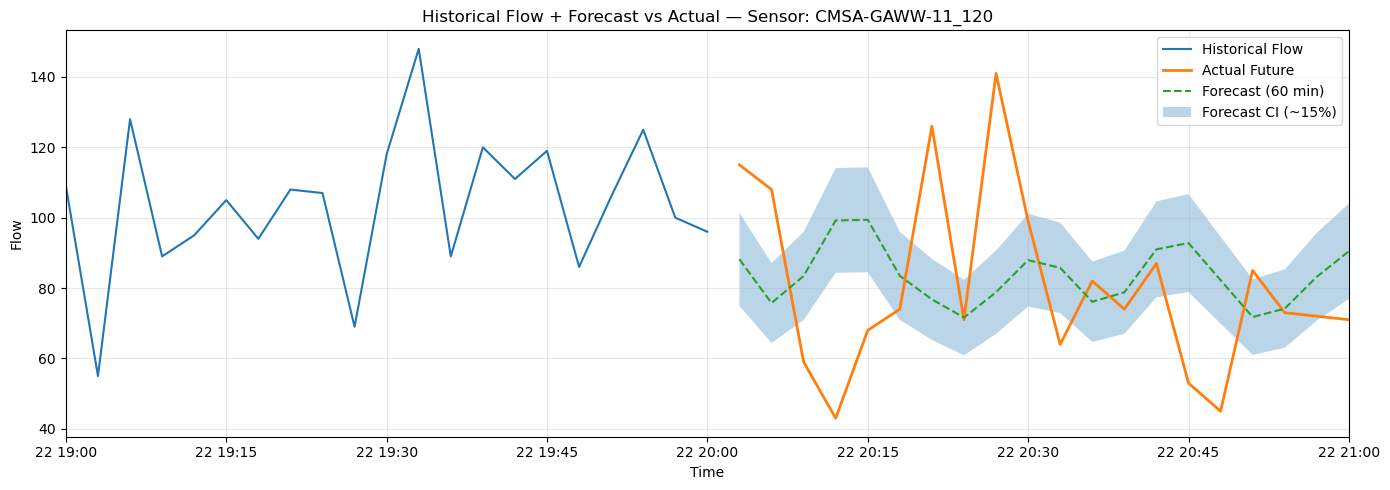

In [ ]:
plot_recursive_forecast2(
    df=df_flow,
    model=model,
    sensor=SENSOR_COL,
    target_time="2025-08-22 20:00:00",  # kies een tijd in jouw data
    forecast_minutes=60,
    FREQ_MIN=FREQ_MIN, LAGS=LAGS, ROLLS=ROLLS, HORIZON_STEPS=H
)